In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import cv2

from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

from utils import convert_image, center_crop, convert_to_y_channel
from models import Generator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Создадим генератор

In [2]:
model = Generator(n_blocks=16, scaling_factor=4)

Загрузим веса

In [4]:
# путь к весам моделей
srgan_checkpoint = "./weights/SRGAN_16blocks_4x.pth"
srresnet_checkpoint = "./weights/SRResNet_16blocks_4x.pth"

# поставьте checkpoint той модели, которую хотите протеститровать
model.load_state_dict(torch.load(srgan_checkpoint))
model.to(device) # перенесем модель на вычислительное устройство
model.eval() # переведем в режим проверки, чтобы batch-norm слои не меняли свои значения

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "upsample_blocks.0.conv.weight", "upsample_blocks.0.conv.bias", "upsample_blocks.1.conv.weight", "upsample_blocks.1.conv.bias". 
	Unexpected key(s) in state_dict: "subpixel_convolutional_blocks.0.conv.weight", "subpixel_convolutional_blocks.0.conv.bias", "subpixel_convolutional_blocks.0.prelu.weight", "subpixel_convolutional_blocks.1.conv.weight", "subpixel_convolutional_blocks.1.conv.bias", "subpixel_convolutional_blocks.1.prelu.weight". 

Загружаем тестовые изображения

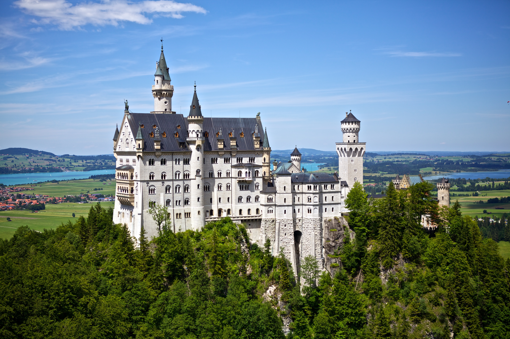

In [42]:
with open('./jsons/test_images.json', 'rt') as f:
    test_images = json.loads(f.read())

img_path = test_images[1]
hr_img = Image.open(img_path, mode="r").convert('RGB')
lr_img = hr_img.resize((hr_img.width//4, hr_img.height//4), Image.BICUBIC)
lr_img.show()

Увеличиваем изображение нейросетью

In [45]:
# увеличение изображения обычной бикубической интерполяцией
bicubic_img = lr_img.resize((lr_img.width*4, lr_img.height*4), Image.BICUBIC)

# увеличение изображения с помощью нейросети!
sr_img = model(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
sr_img = torch.clamp(sr_img.squeeze(0).cpu().detach(),-1,1)
sr_img = convert_image(sr_img, source='[-1, 1]', target='pil')

Посмотрим результат!

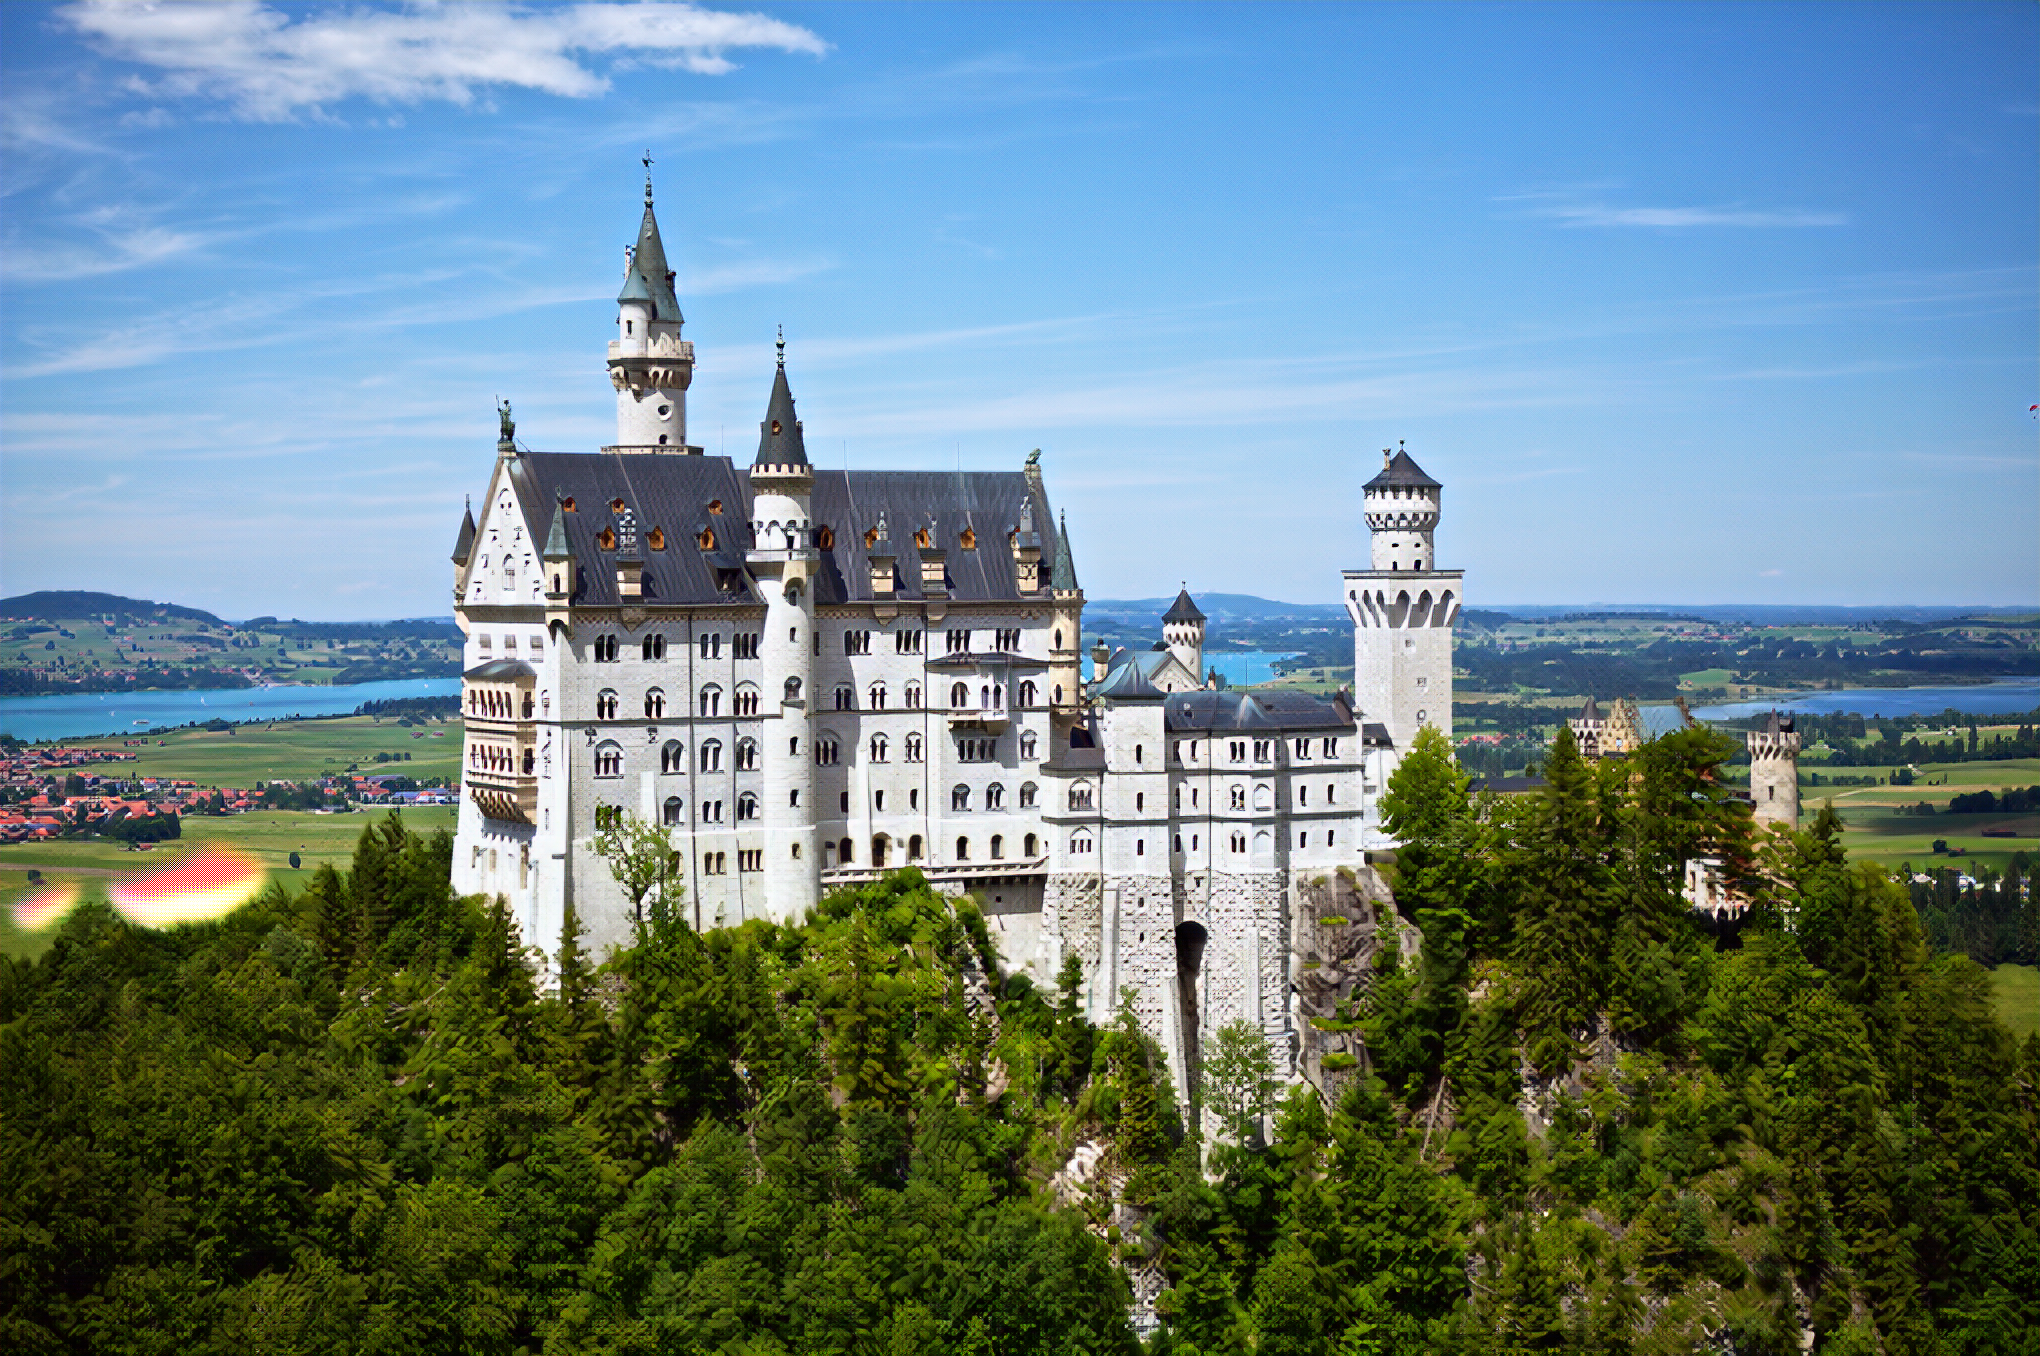

In [46]:
sr_img.show()

Проверим результат с помощью метрик PSNR и SSIM. <br>
Эти метрики основаны на MSE, поэтому SRResNet показывает на них качество лучше, чем SRGAN. Однако человеку более реалистичными кажутся изображения, полученные с помощью SRGAN.

In [29]:
sr_img_y = convert_to_y_channel(sr_img)
bicubic_y = convert_to_y_channel(bicubic_img)
hr_img_y = convert_to_y_channel(hr_img)

print('structure similarity on super resolution image:', SSIM(sr_img_y, hr_img_y, data_range=255.))
print('structure similarity on bicubic interpolation image:', SSIM(bicubic_y, hr_img_y, data_range=255.))

structure similarity on super resolution image: 0.6845885149787257
structure similarity on bicubic interpolation image: 0.706194431016602


Попробуйте сначала загрузить веса SRResNet и посмотреть на значение SSIM, а затем сделать то же самое, загрузив веса SRGAN. Значение SSIM у SRGAN меньше, но изображение выглядит более качественным. <br>

Поздравляю! У вас получилось обучить нейросеть, которая делает Super Resolution изображений!